In [43]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 250.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 MB 1.1 MB/s eta 0:00:0000:0100:06m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 741.3 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 784.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 1.3 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 1.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 983.3 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.1/305.1 kB 1.6 MB/s eta 0:00:00a 0:00:01


In [6]:
!pip3 install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 428.8 kB/s eta 0:00:0000:0100:04


In [7]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [9]:
zip_file_path = "archive.zip"
extract_data = "./extracted_data"  

if not os.path.exists(extract_data):
    os.makedirs(extract_data)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_data)

In [11]:
# Get a list of all files and directories
extracted_files = os.listdir(extract_data)
print("Extracted Files and Directories:", extracted_files)

Extracted Files and Directories: ['Test', 'Train']


In [13]:
# Define paths for train and test directories
train_dir = os.path.join(extract_data, "train")
test_dir = os.path.join(extract_data, "test")


# Display the directory paths
print(f"Train - Directory: {train_dir}")
print(f"Test - Directory: {test_dir}")

Train - Directory: ./extracted_data/train
Test - Directory: ./extracted_data/test


In [15]:
# Set up ImageDataGenerators for loading images
train_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Rescale pixel values to [0,1]
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Rescale pixel values to [0,1]

In [17]:
# Load images from train directory
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=32, 
    class_mode='input',  
    shuffle=True
)

# Load images from test directory
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),  
    batch_size=32,  
    class_mode='input',  #
    shuffle=False
)


Found 1400 images belonging to 2 classes.
Found 380 images belonging to 2 classes.


In [19]:
import numpy as np

# Initialize empty lists to hold image data
X_train = []
X_test = []

# Define num_train_samples and num_test_samples based on the generator's n attribute
num_train_samples = train_generator.n
num_test_samples = test_generator.n

# Iterate through the train generator and store images in X_train
for batch in train_generator:
    X_train.append(batch[0])  
    if len(X_train) * train_generator.batch_size >= num_train_samples:
        break

# Iterate through the test generator and store images in X_test
for batch in test_generator:
    X_test.append(batch[0])
    if len(X_test) * test_generator.batch_size >= num_test_samples:
        break

# Convert lists to numpy arrays
X_train = np.concatenate(X_train, axis=0)
X_test = np.concatenate(X_test, axis=0)

# Output shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (1400, 224, 224, 3)
X_test shape: (380, 224, 224, 3)


In [21]:
import cv2
import numpy as np

# Define the Encoder
encoder_input = keras.Input(shape=(224, 224, 3), name='img')  # Updated to 224x224x3 input
x = keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_input)
x = keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
encoder_output = keras.layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,416 (1.48 MB)

 Trainable params: 388,416 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Define the Decoder
decoder_input = keras.layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(encoder_output)
x = keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(decoder_input)
x = keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_output = keras.layers.Conv2DTranspose(3, 3, activation="sigmoid", strides=2, padding="same")(x)  # Output should be (224, 224, 3)

# Create the Autoencoder Model
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 56, 56, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 112, 112, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 776,579 (2.96 MB)

 Trainable params: 776,579 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Compile the Autoencoder
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
autoencoder.compile(optimizer=opt, loss='mse')

# Train the Autoencoder
epochs = 10
for epoch in range(epochs):
    print(f"Training epoch {epoch + 1}...")
    autoencoder.fit(
        X_train,
        X_train,  # Use X_train as both input and target
        epochs=1,
        batch_size=32,
        validation_split=0.10
    )
    

/opt/anaconda3/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Training epoch 1...
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 374ms/step - loss: 0.0624 - val_loss: 0.0446
Training epoch 2...
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 375ms/step - loss: 0.0426 - val_loss: 0.0275
Training epoch 3...
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 384ms/step - loss: 0.0223 - val_loss: 0.0126
Training epoch 4...
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 406ms/step - loss: 0.0134 - val_loss: 0.0108
Training epoch 5...
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 409ms/step - loss: 0.0113 - val_loss: 0.0101
Training epoch 6...
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 413ms/step - loss: 0.0107 - val_loss: 0.0093
Training epoch 7...
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 418ms/step - loss: 0.0103 - val_loss: 0.0090
Training epoch 8...
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 427ms/step - loss: 0.0098 - val_loss: 0.0085
Training epoch 9...
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 428ms/step - loss: 0.0094 - val_loss: 0.0077
Training epoch 10...
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 425ms/step - loss: 0.0084 - val_loss: 0.0079


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Calculate metrics for a batch of images
def calculate_metrics(original, reconstructed):
    # Ensure both images have the same dimensions
    if original.shape != reconstructed.shape:
        raise ValueError(f"Shape mismatch: original image shape {original.shape} vs reconstructed shape {reconstructed.shape}")
    
    # Convert to range [0, 255] (SSIM and PSNR expect this range for RGB images)
    original = (original * 255.0).astype("uint8")
    reconstructed = (reconstructed * 255.0).astype("uint8")

    # MSE (Mean Squared Error)
    mse_value = np.mean((original - reconstructed) ** 2)
    
    # SSIM (Structural Similarity Index)
    try:
        ssim_value = ssim(original, reconstructed, data_range=255, win_size=7, channel_axis=-1)
    except ValueError:
        # Fallback: Use the minimum odd window size possible for the image dimensions
        win_size = min(original.shape[0], original.shape[1], 7)  # Ensure win_size fits within the image dimensions
        if win_size % 2 == 0:
            win_size -= 1  # Make it odd
        ssim_value = ssim(original, reconstructed, data_range=255, win_size=win_size, channel_axis=-1)
    
    # PSNR (Peak Signal to Noise Ratio)
    psnr_value = psnr(original, reconstructed, data_range=255)

    return mse_value, ssim_value, psnr_value

# Evaluate the autoencoder on the test set and compute the metrics
total_mse, total_ssim, total_psnr = 0, 0, 0
num_examples = len(X_test)  # Total number of test examples

In [29]:
# Use the first test image from X_test and reshape it for prediction
example = encoder.predict([X_test[0].reshape(-1, 224, 224, 3)])

# Print the shape of the encoded representation
print("Encoded shape:", example.shape)

# Print the encoded output
print("Encoded output:", example)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Encoded shape: (1, 14, 14, 256)
Encoded output: [[[[0.04045571 0.         0.         ... 0.12394652 0.2685398
    0.        ]
   [0.         0.         0.         ... 0.1383524  0.312792
    0.        ]
   [0.         0.         0.         ... 0.22159298 0.36093736
    0.        ]
   ...
   [0.         0.         0.         ... 0.24689493 0.34780458
    0.        ]
   [0.01094301 0.         0.         ... 0.25313252 0.2965005
    0.        ]
   [0.         0.         0.07466868 ... 0.14757182 0.25896263
    0.08420441]]

  [[0.01326311 0.         0.         ... 0.14252253 0.29429328
    0.        ]
   [0.         0.         0.         ... 0.15618649 0.33797237
    0.        ]
   [0.         0.         0.         ... 0.2759867  0.42551157
    0.        ]
   ...
   [0.         0.         0.         ... 0.26831785 0.4374677
    0.        ]
   [0.         0.         0.         ... 0.31554747 0.29222515
    0.        ]
   [0.         0.         0.161469

/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: img. Received: the structure of inputs=('*',)
  warnings.warn(


Encoded shape: (1, 14, 14, 256)


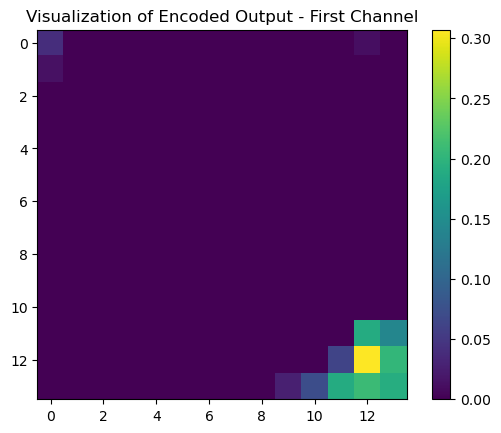

In [31]:
import matplotlib.pyplot as plt

# Assuming `example` is the latent representation from the encoder with shape (1, height, width, channels)
print("Encoded shape:", example.shape)

# Extract the first image and a single channel (e.g., the first channel)
encoded_image = example[0]  # Remove batch dimension
channels = encoded_image.shape[-1]  # Number of channels

# Visualize the first channel of the encoded image
if channels > 1:
    plt.imshow(encoded_image[:, :, 0], cmap="viridis")  # Visualize first channel with a color map
else:
    plt.imshow(encoded_image[:, :, 0], cmap="gray")  # Visualize in grayscale if single channel

plt.colorbar()
plt.title("Visualization of Encoded Output - First Channel")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


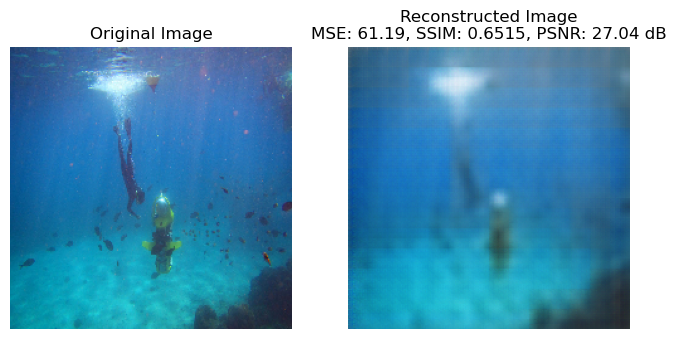

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


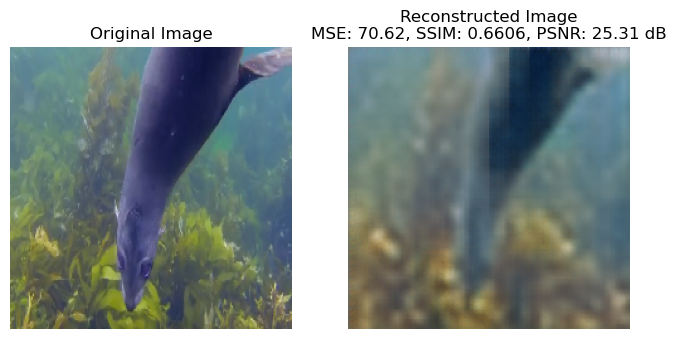

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


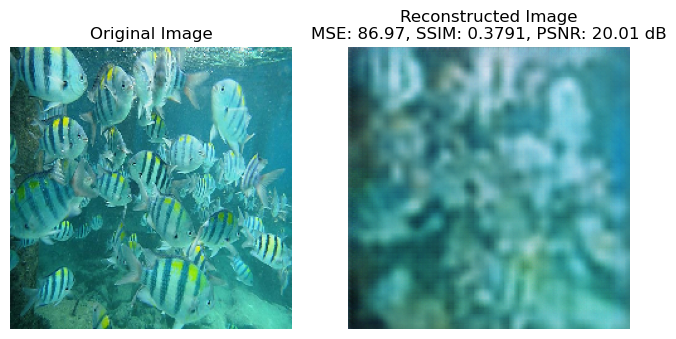

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


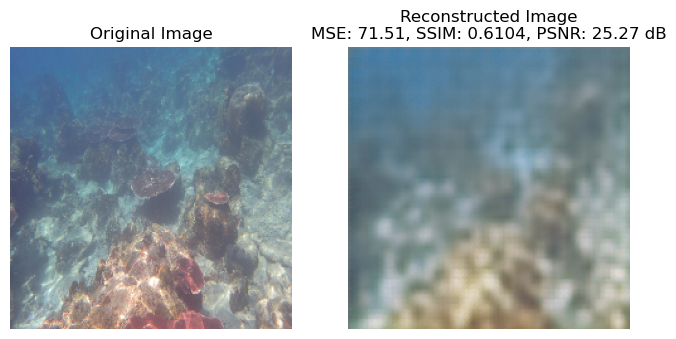

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


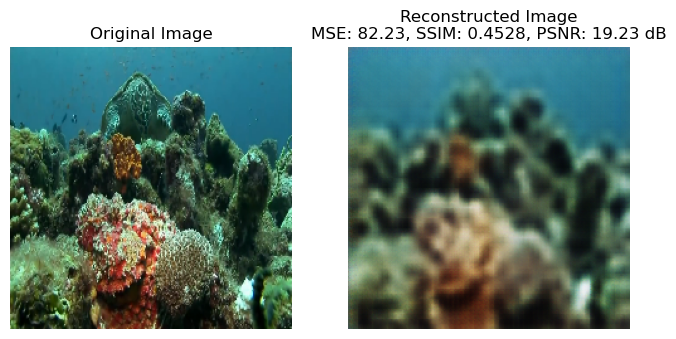

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

In [ ]:
for idx, d in enumerate(X_test):
    # Predict the reconstructed image using the autoencoder
    ae_out = autoencoder.predict([d.reshape(-1, 224, 224, 3)])  # Reshape the image for the autoencoder
    reconstructed_img = ae_out[0]

    # Calculate metrics
    mse_value, ssim_value, psnr_value = calculate_metrics(d, reconstructed_img)

    # Accumulate the metrics for averaging later
    total_mse += mse_value
    total_ssim += ssim_value
    total_psnr += psnr_value

    # Display images and metrics for the first few examples
    if idx < 5:  # Show only the first 5 examples
        plt.figure(figsize=(8, 4))
        
        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(d)
        plt.title("Original Image")
        plt.axis('off')
        
        # Reconstructed Image
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed_img)
        plt.title(f"Reconstructed Image\nMSE: {mse_value:.2f}, SSIM: {ssim_value:.4f}, PSNR: {psnr_value:.2f} dB")
        plt.axis('off')
        
        plt.show()

# Calculate average values
avg_mse = total_mse / num_examples
avg_ssim = total_ssim / num_examples
avg_psnr = total_psnr / num_examples

# Display final average scores
print(f"Average MSE: {avg_mse:.2f}")
print(f"Average SSIM: {avg_ssim:.4f}")
print(f"Average PSNR: {avg_psnr:.2f} dB")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Original shape: (224, 224, 3), Reconstructed shape: (224, 224, 3)


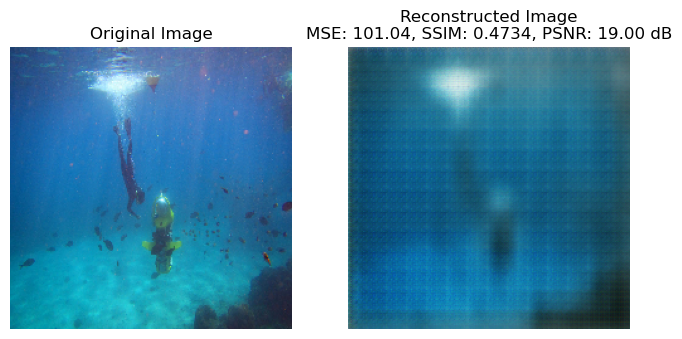

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Original shape: (224, 224, 3), Reconstructed shape: (224, 224, 3)


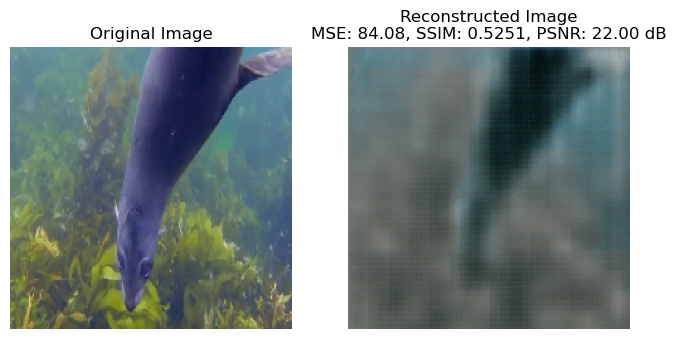

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Original shape: (224, 224, 3), Reconstructed shape: (224, 224, 3)


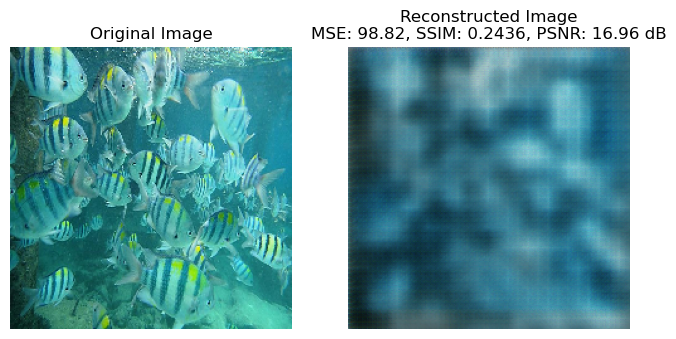

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Original shape: (224, 224, 3), Reconstructed shape: (224, 224, 3)


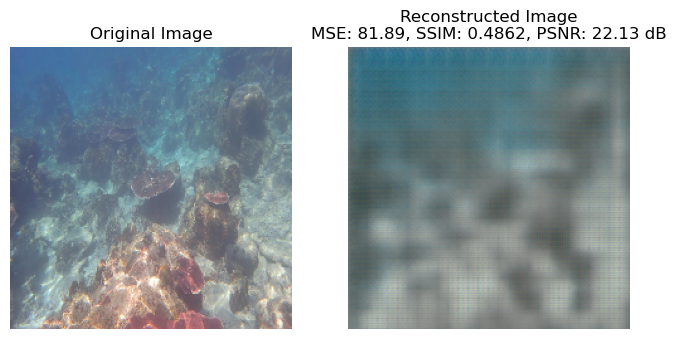

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Original shape: (224, 224, 3), Reconstructed shape: (224, 224, 3)


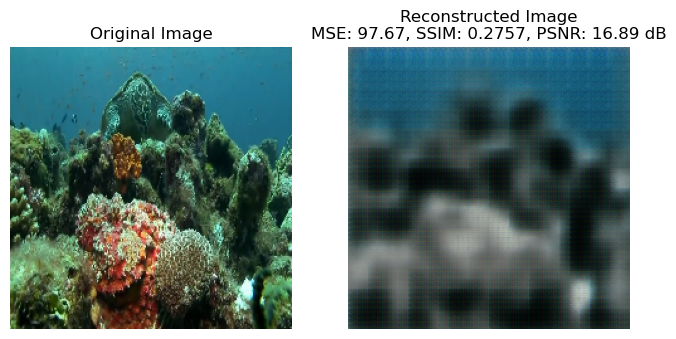

In [39]:
# Display original, reconstructed images and their scores
num_examples = 5
for idx, d in enumerate(X_test[:num_examples]):
    ae_out = autoencoder.predict([d.reshape(-1, 224, 224, 3)])
    reconstructed_img = ae_out[0]

    # Print shape for debugging
    print(f"Original shape: {d.shape}, Reconstructed shape: {reconstructed_img.shape}")
    
    # Calculate metrics
    mse_value, ssim_value, psnr_value = calculate_metrics(d, reconstructed_img)

    # Display images and metrics
    plt.figure(figsize=(8, 4))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(d)
    plt.title("Original Image")
    plt.axis('off')
    
    # Reconstructed Image
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img)
    plt.title(f"Reconstructed Image\nMSE: {mse_value:.2f}, SSIM: {ssim_value:.4f}, PSNR: {psnr_value:.2f} dB")
    plt.axis('off')
    
    plt.show()
    